In [34]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Define file path and load all Excel files
folder_path = 'evaluation_rags'
excel_files = glob(os.path.join(folder_path, "*.csv"))

# Create an empty DataFrame to store all data
all_data = pd.DataFrame()

# Load data from each file and append it to the DataFrame
for file in excel_files:
    data = pd.read_csv(file)
    
    # Extract relevant config info from the file name
    file_info = os.path.basename(file).replace(".csv", "").split("_")
    optimizer = 'optimizer' in file_info
    index = file_info[0].split("-")[0]
    config = index + "_" + file_info[1]
    rag_model = file_info[1]
    additional_flags = "_".join([x for x in file_info if x in ["rerank", "rephrase", "enrich"]])
    additional_flags = additional_flags if additional_flags else "none"
    mode = "Direct" if "Direct" in file_info else "RAG"
    
    # Add extracted config info as new columns
    data['optimizer'] = optimizer
    data['config'] = config
    data['rag_model'] = rag_model
    data['additional_flags'] = additional_flags
    data['mode'] = mode
    data['index'] = index
    

    # Convert similarity_score to a numeric average if it's a list
    try:
        data['similarity_score'] = data['similarity_score'].apply(lambda x: sum(eval(x)) / len(eval(x)) if isinstance(x, str) else x)
    except Exception as e:
        print(f"Error converting similarity scores in file {file}: {e}")
        continue  # Skip files with errors
    
    all_data = pd.concat([all_data, data], ignore_index=True)

all_data['eval_correctness'] = all_data['eval_correctness'].apply(lambda x: 1 if x == "Correct" else 0)


# Ensure all eval columns are numeric for aggregation
for col in ['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence', 'eval_correctness']:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')



# Calculate mean similarity scores and aggregate eval columns for analysis
agg_data = all_data.groupby(['config', 'rag_model', 'optimizer', 'additional_flags', 'mode']).agg(
    mean_similarity_score=('similarity_score', 'mean'),
    max_similarity_score=('similarity_score', 'max'),
    factuality=('eval_factuality', 'mean'),
    relevance=('eval_relevance', 'mean'),
    completeness=('eval_completeness', 'mean'),
    confidence=('eval_confidence', 'mean'),
    correctness=('eval_correctness', 'mean')
).reset_index()

# Select top 20 configurations by mean similarity score
top_20_by_similarity = agg_data[agg_data['mode'] == 'RAG'].nlargest(20, 'mean_similarity_score')
top_20_by_correctness = agg_data[agg_data['mode'] == 'RAG'].nlargest(20, 'correctness')
top_20_by_factuality = agg_data[agg_data['mode'] == 'RAG'].nlargest(20, 'factuality')

# Plotting section
sns.set(style="whitegrid")

### Visual

In [48]:
def to_pastel(color):
    return sns.light_palette(color, n_colors=1, reverse=True)[0]


def get_warm_colors(n_colors):
    return [to_pastel(i) for i in sns.color_palette("YlOrRd", n_colors)]


def get_cold_colors(n_colors):
    return [to_pastel(i) for i in sns.color_palette("Blues", n_colors)]


def get_palette(two_n_colors):
    n_colors = two_n_colors // 2

    warm_colors = get_warm_colors(n_colors)
    cold_colors = get_cold_colors(n_colors)
    cold_colors.reverse()

    return cold_colors + warm_colors


def get_medians(data, group_by, column):
    return data.groupby(group_by)[column].median().sort_values(ascending=False)

In [49]:
rag_all_data = all_data[all_data['mode'] == 'RAG']
rag_agg_data = rag_all_data.groupby(['config', 'additional_flags']).agg(
    mean_similarity_score=('similarity_score', 'mean'),
    mean_factuality=('eval_factuality', 'mean'),
    mean_relevance=('eval_relevance', 'mean'),
    mean_completeness=('eval_completeness', 'mean'),
    mean_confidence=('eval_confidence', 'mean'),
    mean_correctness=('eval_correctness', 'mean'),
).reset_index()

rag_agg_data['mean_overall_score'] = rag_agg_data[['mean_factuality', 'mean_relevance', 'mean_completeness', 'mean_confidence']].mean(axis=1)
rag_agg_data['median_overall_score'] = rag_agg_data[['mean_factuality', 'mean_relevance', 'mean_completeness', 'mean_confidence']].median(axis=1)

In [50]:
rag_top_10_by_overall_score = rag_agg_data.nlargest(10, 'median_overall_score')
rag_low_10_by_overall_score = rag_agg_data.nsmallest(10, 'median_overall_score')
rag_relevant_confings_and_flags = pd.concat([rag_top_10_by_overall_score, rag_low_10_by_overall_score])[['config', 'additional_flags']].drop_duplicates()

In [51]:
rag_all_data['overall_score'] = rag_all_data[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)
proccessed_data = rag_all_data.merge(rag_relevant_confings_and_flags, on=['config', 'additional_flags'])
proccessed_data['setup'] = proccessed_data['config'] + "_" + proccessed_data['additional_flags']
medians = get_medians(proccessed_data, 'setup', 'overall_score')
proccessed_data['setup'] = pd.Categorical(proccessed_data['setup'], categories=medians.index, ordered=True)
palette = get_palette(20)
color_mapping = {setup: palette[i] for i, setup in enumerate(medians.index)}

/tmp/ipykernel_5382/2693202431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rag_all_data['overall_score'] = rag_all_data[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)


/tmp/ipykernel_5382/3905771199.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall_score', y='setup', data=proccessed_data, orient='h', width=0.5, palette=color_mapping)


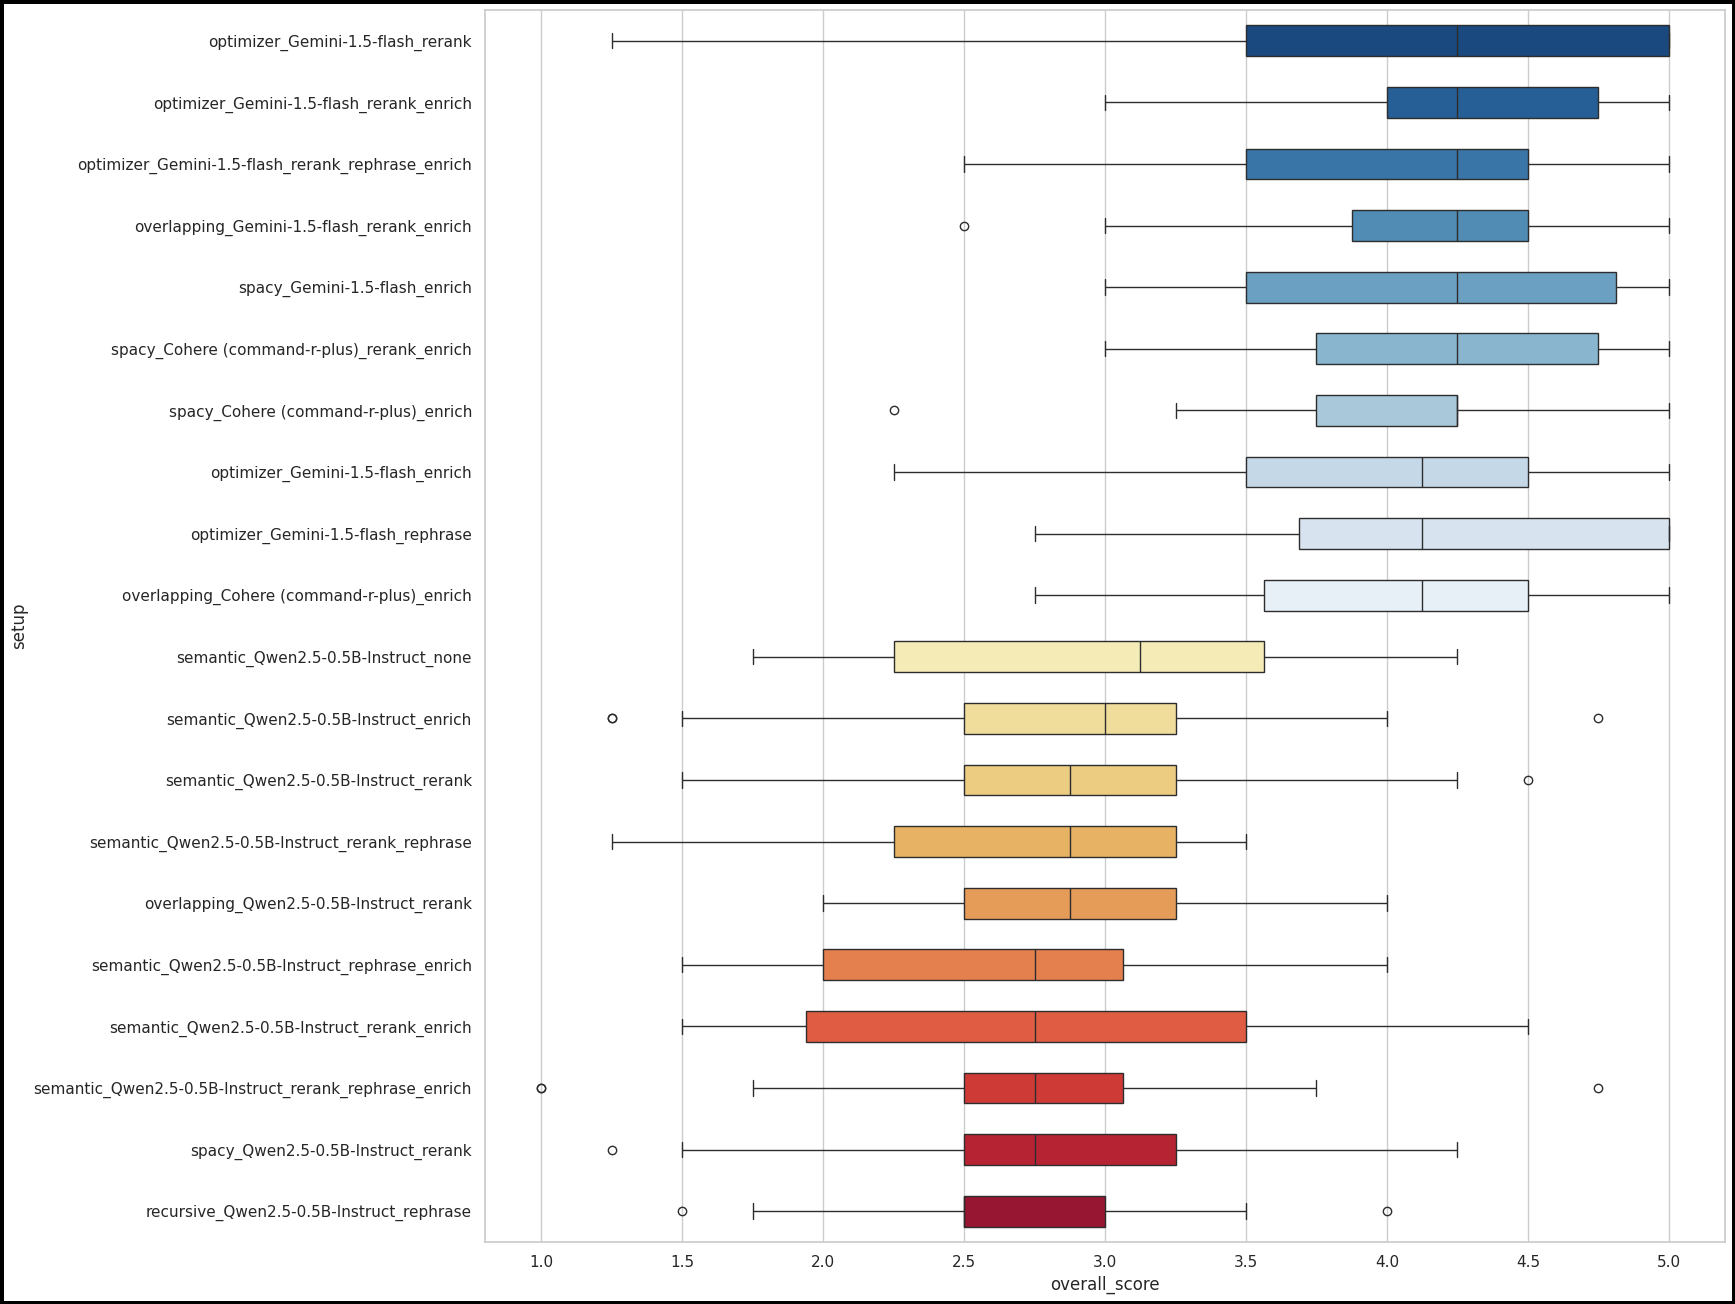

In [53]:
fig = plt.figure(figsize=(16, 16))
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(5)
sns.boxplot(x='overall_score', y='setup', data=proccessed_data, orient='h', width=0.5, palette=color_mapping)
plt.show()

In [8]:
data_without_optimizer = all_data[~all_data['optimizer']]
data_without_optimizer['overall_score'] = data_without_optimizer[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)
table = data_without_optimizer.groupby(['rag_model', 'mode']).agg(
    mean_factuality=('eval_factuality', 'mean'),
    mean_relevance=('eval_relevance', 'mean'),
    mean_completeness=('eval_completeness', 'mean'),
    mean_confidence=('eval_confidence', 'mean'),
    mean_overall_score=('overall_score', 'mean'),
).T

/tmp/ipykernel_5382/1155977215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_optimizer['overall_score'] = data_without_optimizer[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)


In [19]:
order = ''
latex_code = {
    'Cohere (command-r-plus)': {
        'RAG': '',
        'Direct': '',
        'Diff': ''
    },
    'Gemini-1.5-flash': {
        'RAG': '',
        'Direct': '',
        'Diff': ''
    },
    'Qwen2.5-0.5B-Instruct': {
        'RAG': '',
        'Direct': '',
        'Diff': ''
    }
}
# rag_model_results = {}

# Iterate over the rows of the DataFrame
for mode, group in table.groupby(level=0):
    # rag_model_results[mode] = {}
    order += f' & {mode}'

    for row in group.itertuples(index=False):
        latex_code['Cohere (command-r-plus)']['Direct'] += f' & {row[0]:.2f}'
        latex_code['Cohere (command-r-plus)']['RAG'] += f' & {row[1]:.2f}'
        latex_code['Cohere (command-r-plus)']['Diff'] += f' & {round(row[1], 2) - round(row[0], 2):.2f}'
        latex_code['Gemini-1.5-flash']['Direct'] += f' & {row[2]:.2f}'
        latex_code['Gemini-1.5-flash']['RAG'] += f' & {row[3]:.2f}'
        latex_code['Gemini-1.5-flash']['Diff'] += f' & {round(row[3], 2) - round(row[2], 2):.2f}'
        latex_code['Qwen2.5-0.5B-Instruct']['Direct'] += f' & {row[4]:.2f}'
        latex_code['Qwen2.5-0.5B-Instruct']['RAG'] += f' & {row[5]:.2f}'
        latex_code['Qwen2.5-0.5B-Instruct']['Diff'] += f' & {round(row[5], 2) - round(row[4], 2):.2f}'

        # rag_model_results[mode]['Cohere (command-r-plus)'] = {'Direct': row[0], 'RAG': row[1], 'Diff': row[1] - row[0]}
        # rag_model_results[mode]['Gemini-1.5-flash'] = {'Direct': row[2], 'RAG': row[3], 'Diff': row[3] - row[2]}
        # rag_model_results[mode]['Qwen2.5-0.5B-Instruct'] = {'Direct': row[4], 'RAG': row[5], 'Diff': row[5] - row[4]}

In [20]:
order

' & mean_completeness & mean_confidence & mean_factuality & mean_overall_score & mean_relevance'

In [32]:
for llm in latex_code:
    print(f"""& RAG{latex_code[llm]['RAG']} \\\\
\cline{{2-7}}
& Direct{latex_code[llm]['Direct']} \\\\
\cline{{2-7}}
& Diff{latex_code[llm]['Diff']} \\\\
          """)

& RAG & 3.67 & 3.82 & 3.87 & 3.83 & 3.98 \\
\cline{2-7}
& Direct & 3.19 & 3.42 & 3.27 & 3.40 & 3.70 \\
\cline{2-7}
& Diff & 0.48 & 0.40 & 0.60 & 0.43 & 0.28 \\
          
& RAG & 3.61 & 3.74 & 3.82 & 3.78 & 3.96 \\
\cline{2-7}
& Direct & 2.43 & 2.46 & 2.36 & 2.61 & 3.18 \\
\cline{2-7}
& Diff & 1.18 & 1.28 & 1.46 & 1.17 & 0.78 \\
          
& RAG & 2.80 & 2.94 & 2.74 & 2.95 & 3.32 \\
\cline{2-7}
& Direct & 2.39 & 2.62 & 2.14 & 2.49 & 2.79 \\
\cline{2-7}
& Diff & 0.41 & 0.32 & 0.60 & 0.46 & 0.53 \\
          


In [38]:
optimizer_data['optimal_index'].unique()

array(['Recursive Search index', 'Spacy NLP index',
       'Semantic Match index', 'Overlap Strategy index'], dtype=object)

/tmp/ipykernel_5382/146882276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Recursive Search index', 'Recursive Chunking')
/tmp/ipykernel_5382/146882276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Spacy NLP index', 'SpaCy-Based Chunking')
/tmp/ipykernel_5382/146882276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

<AxesSubplot: xlabel='optimal_index', ylabel='count'>

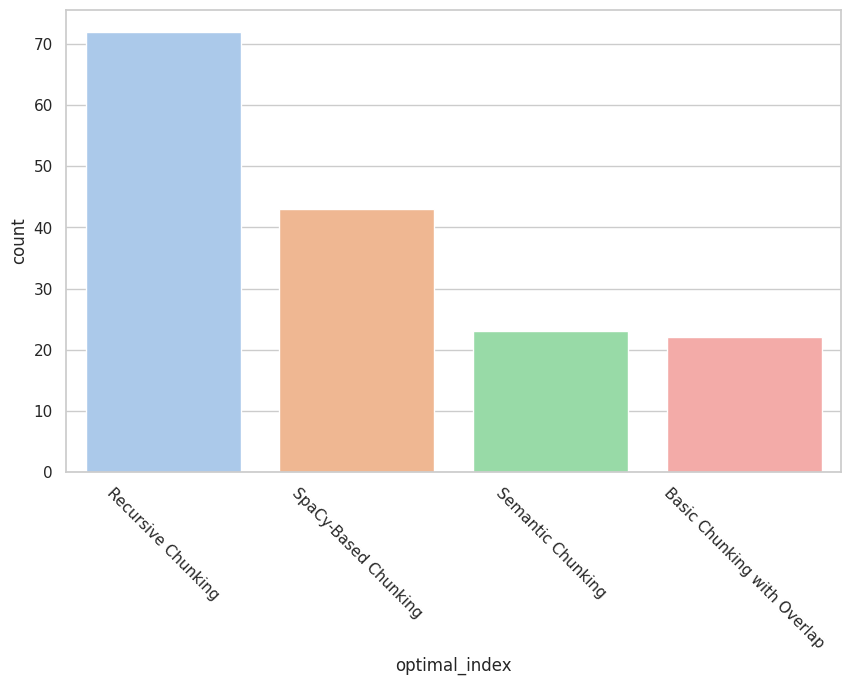

In [43]:
optimizer_data = all_data[all_data['optimizer'] & (all_data['mode'] == 'RAG')]
# Replace all occurrences of 'None' with 'none'
optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Recursive Search index', 'Recursive Chunking')
optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Spacy NLP index', 'SpaCy-Based Chunking')
optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Semantic Match index', 'Semantic Chunking')
optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Overlap Strategy index', 'Basic Chunking with Overlap')

optimizer_data['optimal_index'].value_counts()

# Create histogram for optimal index value counts
# plt.figure(figsize=(10, 6))
# sns.histplot(optimizer_data['optimal_index'], bins=20, kde=True)

plt.figure(figsize=(10, 6))
plt.xticks(rotation=-45)
sns.countplot(x='optimal_index', data=optimizer_data, palette='pastel')

In [11]:
flags_data = all_data[all_data['mode'] == 'RAG'].groupby('additional_flags').agg(
    mean_factuality=('eval_factuality', 'mean'),
    mean_relevance=('eval_relevance', 'mean'),
    mean_completeness=('eval_completeness', 'mean'),
    mean_confidence=('eval_confidence', 'mean'),
).reset_index()

flags_data['mean_overall_score'] = flags_data[['mean_factuality', 'mean_relevance', 'mean_completeness', 'mean_confidence']].mean(axis=1)
flags_data['median_overall_score'] = flags_data[['mean_factuality', 'mean_relevance', 'mean_completeness', 'mean_confidence']].median(axis=1)

In [ ]:
rag_all_data = all_data[all_data['mode'] == 'RAG']
rag_all_data['overall_score'] = rag_all_data[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)
medians = get_medians(rag_all_data, 'additional_flags', 'overall_score')
rag_all_data['additional_flags'] = pd.Categorical(rag_all_data['additional_flags'], categories=medians.index, ordered=True)

/tmp/ipykernel_445634/803841306.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall_score', y='additional_flags', data=rag_all_data, orient='h', width=0.5, palette='pastel')


<AxesSubplot: xlabel='overall_score', ylabel='additional_flags'>

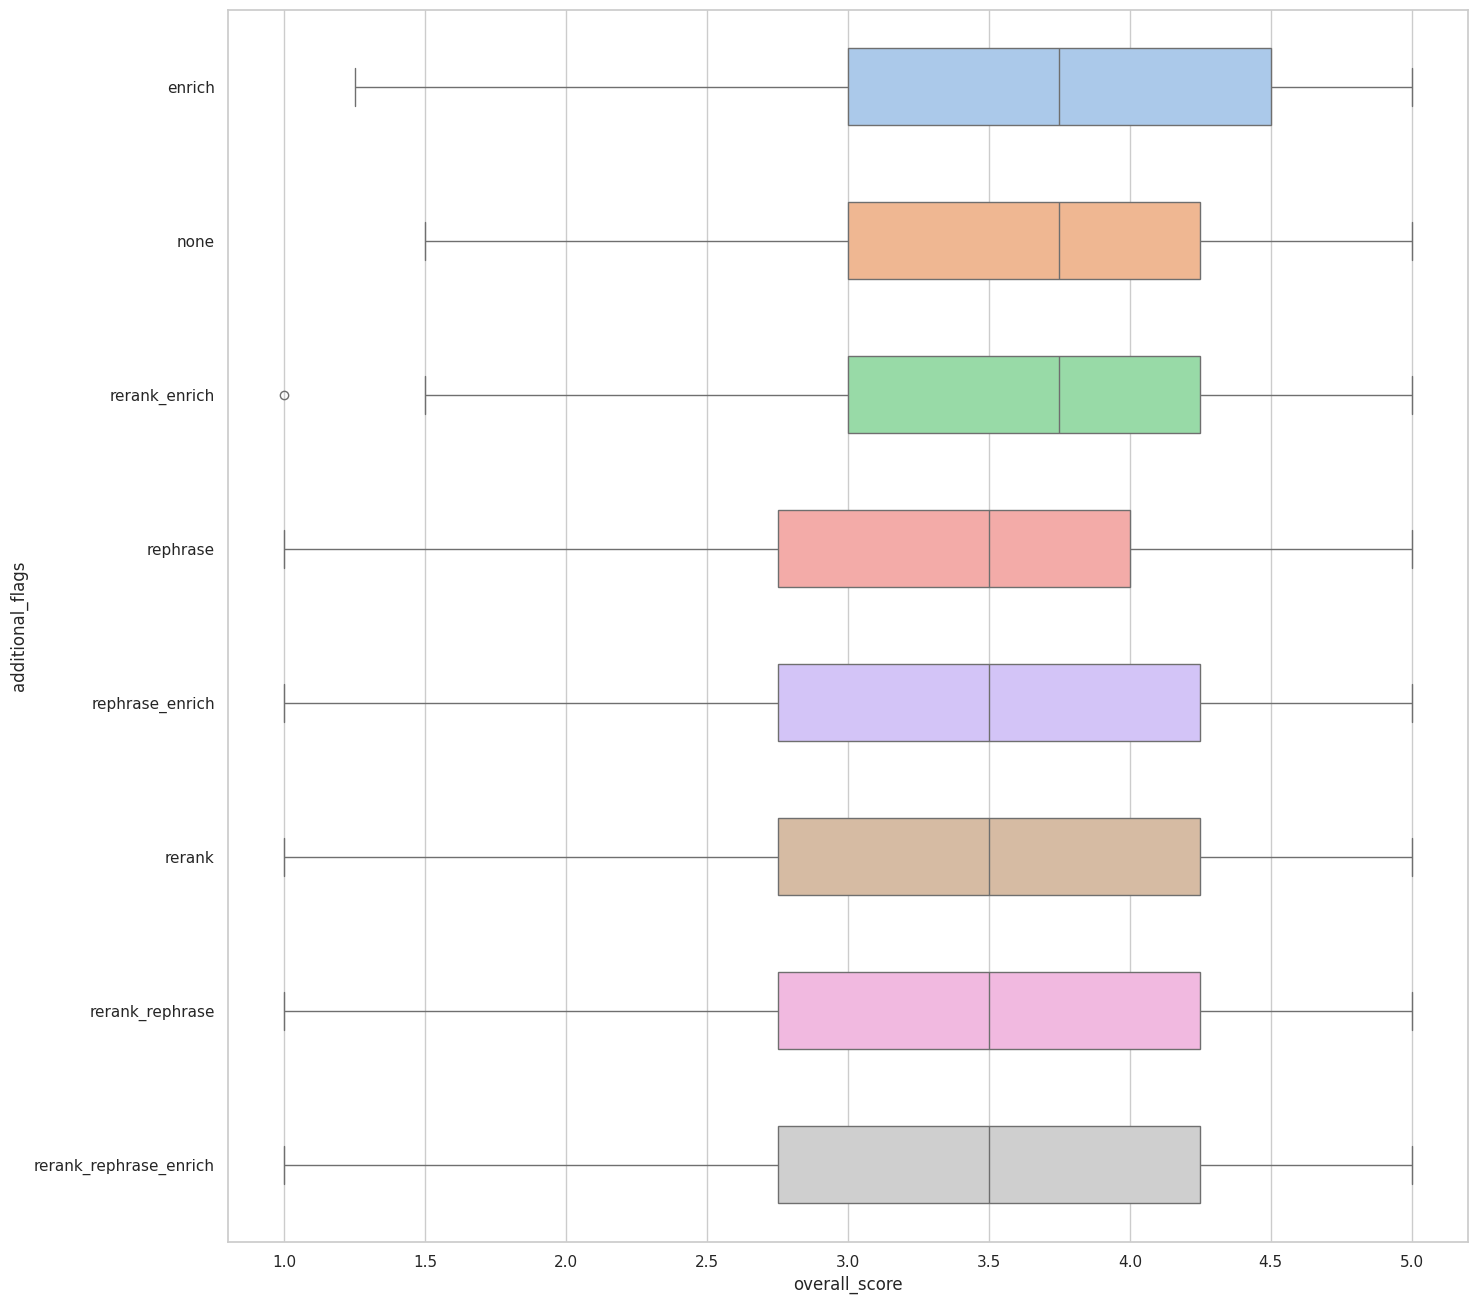

In [13]:
plt.figure(figsize=(16, 16))
sns.boxplot(x='overall_score', y='additional_flags', data=rag_all_data, orient='h', width=0.5, palette='pastel')

In [44]:
similarity_data = all_data[(all_data['mode'] == 'RAG') & (~all_data['optimizer'])].groupby(['config', 'additional_flags']).agg(
    mean_similarity_score=('similarity_score', 'mean'),
).reset_index()

similarity_top_10 = similarity_data.nlargest(10, 'mean_similarity_score')
similarity_low_10 = similarity_data.nsmallest(10, 'mean_similarity_score')
similarity_relevant_confings_and_flags = pd.concat([rag_top_10_by_overall_score, rag_low_10_by_overall_score])[['config', 'additional_flags']].drop_duplicates()

In [ ]:
flags = ['rerank', 'rephrase', 'enrich', 'none']

for flag in flags:
    flag_data = all_data[(all_data['additional_flags'] == flag) & (all_data['mode'] == 'RAG') & (~all_data['optimizer'])]
    medians = flag_data.groupby('index')['similarity_score'].median().sort_values(ascending=False)
    flag_data['index'] = pd.Categorical(flag_data['index'], categories=medians.index, ordered=True)

    plt.figure(figsize=(16, 16))
    sns.boxplot(x='similarity_score', y='index', data=flag_data, orient='h', width=0.5, palette='pastel')

/tmp/ipykernel_5382/3353825013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flag_data['index'] = pd.Categorical(flag_data['index'], categories=medians.index, ordered=True)
/tmp/ipykernel_5382/3353825013.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='similarity_score', y='index', data=flag_data, orient='h', width=0.5, palette='pastel', ax=axes[i])
/tmp/ipykernel_5382/3353825013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

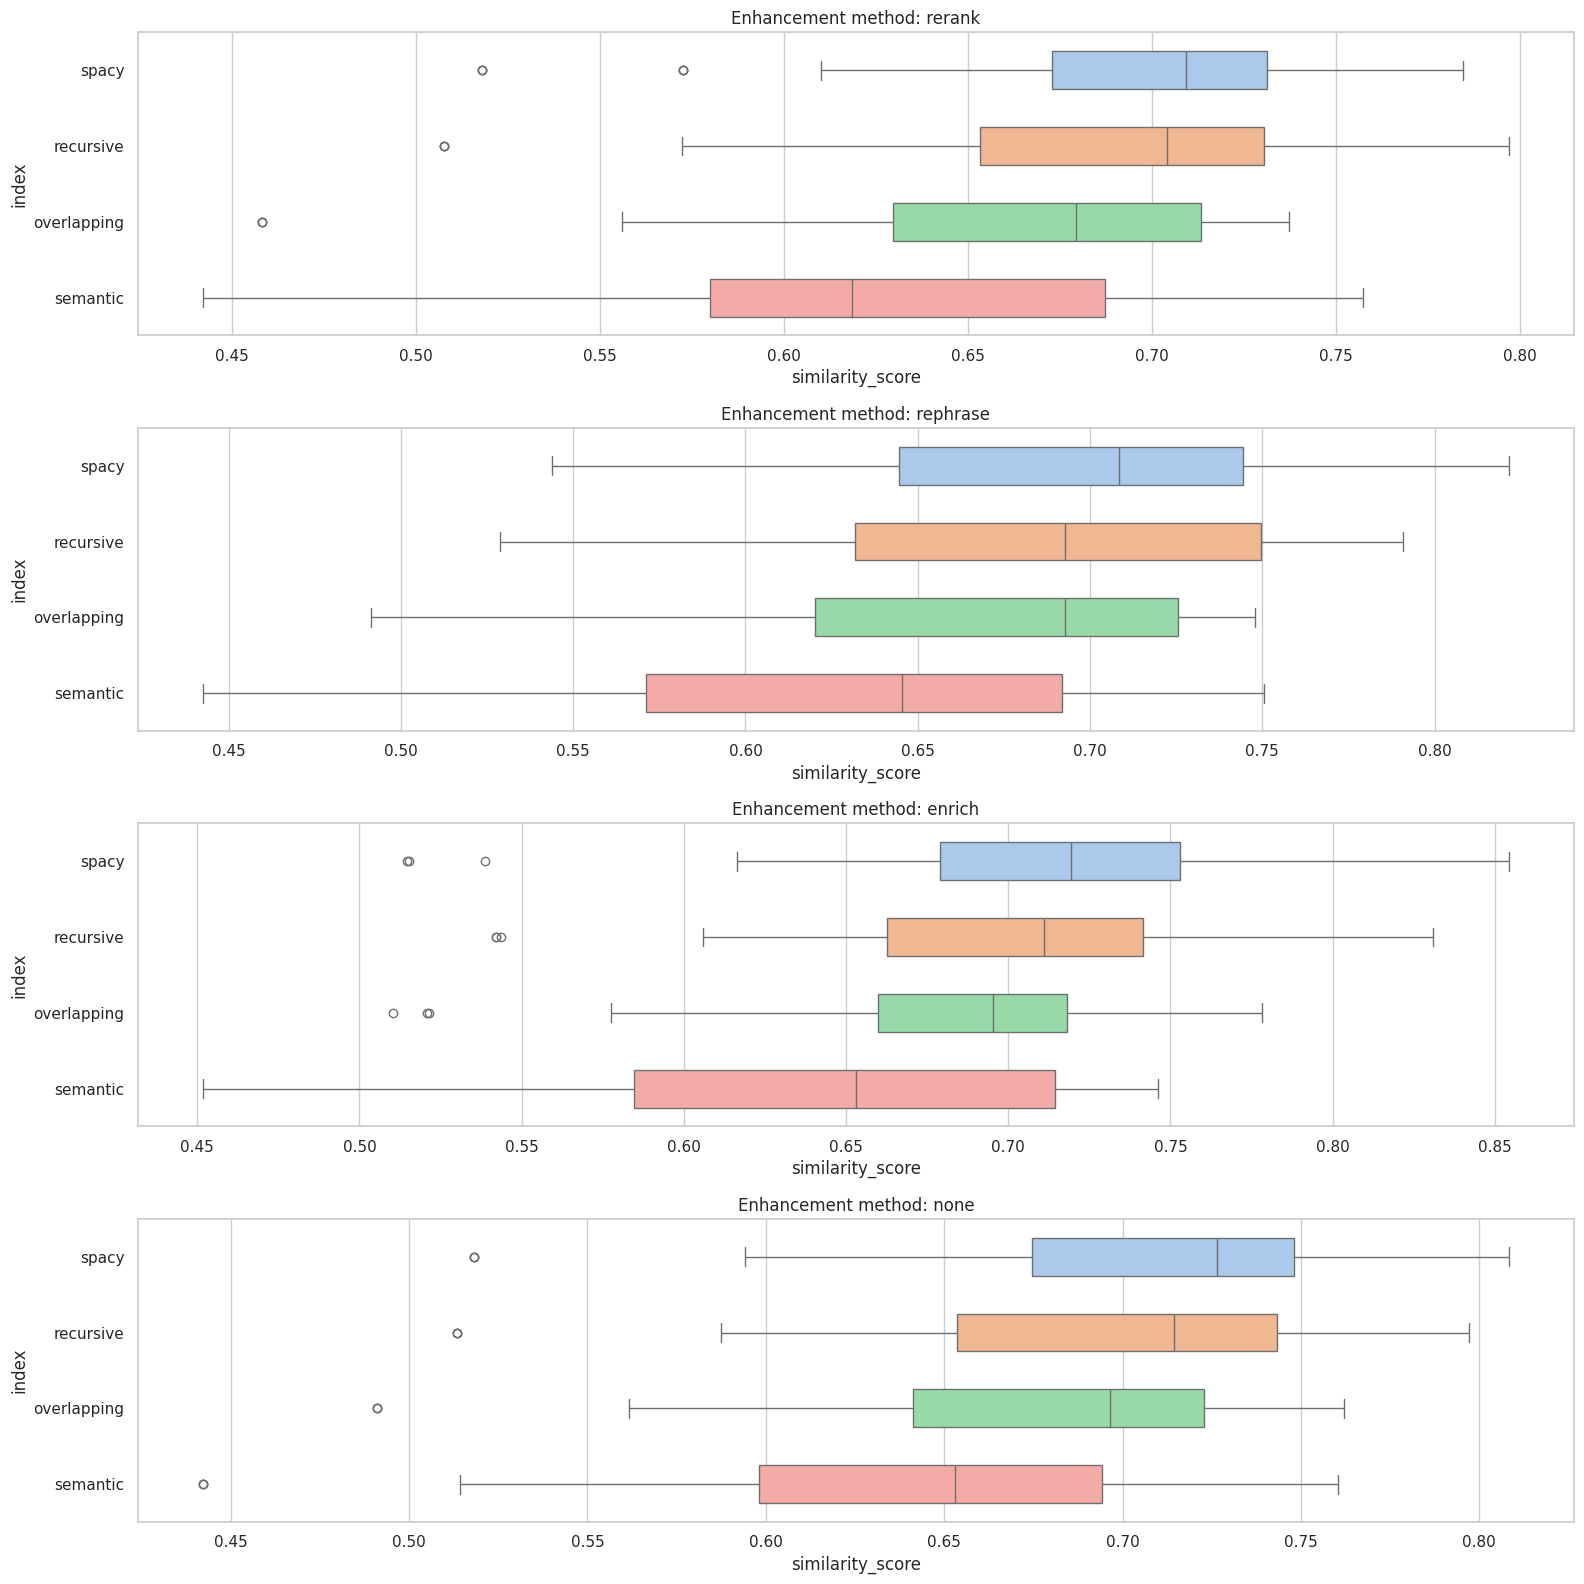

In [46]:
flags = ['rerank', 'rephrase', 'enrich', 'none']
warm_colors = get_warm_colors(6)
cold_colors = get_cold_colors(6)
cold_colors.reverse()
palette = cold_colors + warm_colors

# Create a figure with subplots
fig, axes = plt.subplots(nrows=len(flags), ncols=1, figsize=(16, 4 * len(flags)))

for i, flag in enumerate(flags):
    flag_data = all_data[(all_data['additional_flags'] == flag) & (all_data['mode'] == 'RAG') & (~all_data['optimizer'])]
    medians = flag_data.groupby('index')['similarity_score'].median().sort_values(ascending=False)
    flag_data['index'] = pd.Categorical(flag_data['index'], categories=medians.index, ordered=True)

    # Plot the boxplot in the respective subplot
    sns.boxplot(x='similarity_score', y='index', data=flag_data, orient='h', width=0.5, palette='pastel', ax=axes[i])
    axes[i].set_title(f'Enhancement method: {flag}')

# Adjust layout
plt.tight_layout()
plt.show()

### End

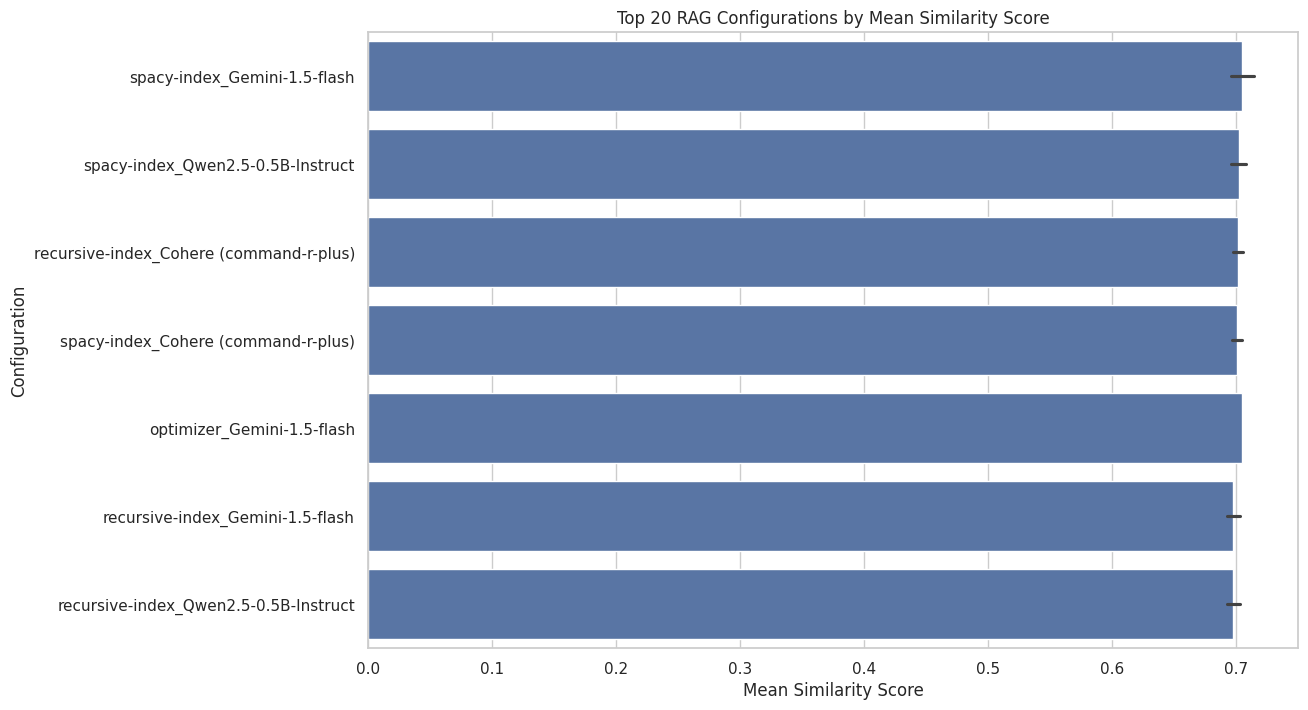

In [11]:

# Plot without `hue` to simplify if needed
plt.figure(figsize=(12, 8))
sns.barplot(x='mean_similarity_score', y='config', data=top_20_by_similarity)
plt.title("Top 20 RAG Configurations by Mean Similarity Score")
plt.xlabel("Mean Similarity Score")
plt.ylabel("Configuration")
plt.show()


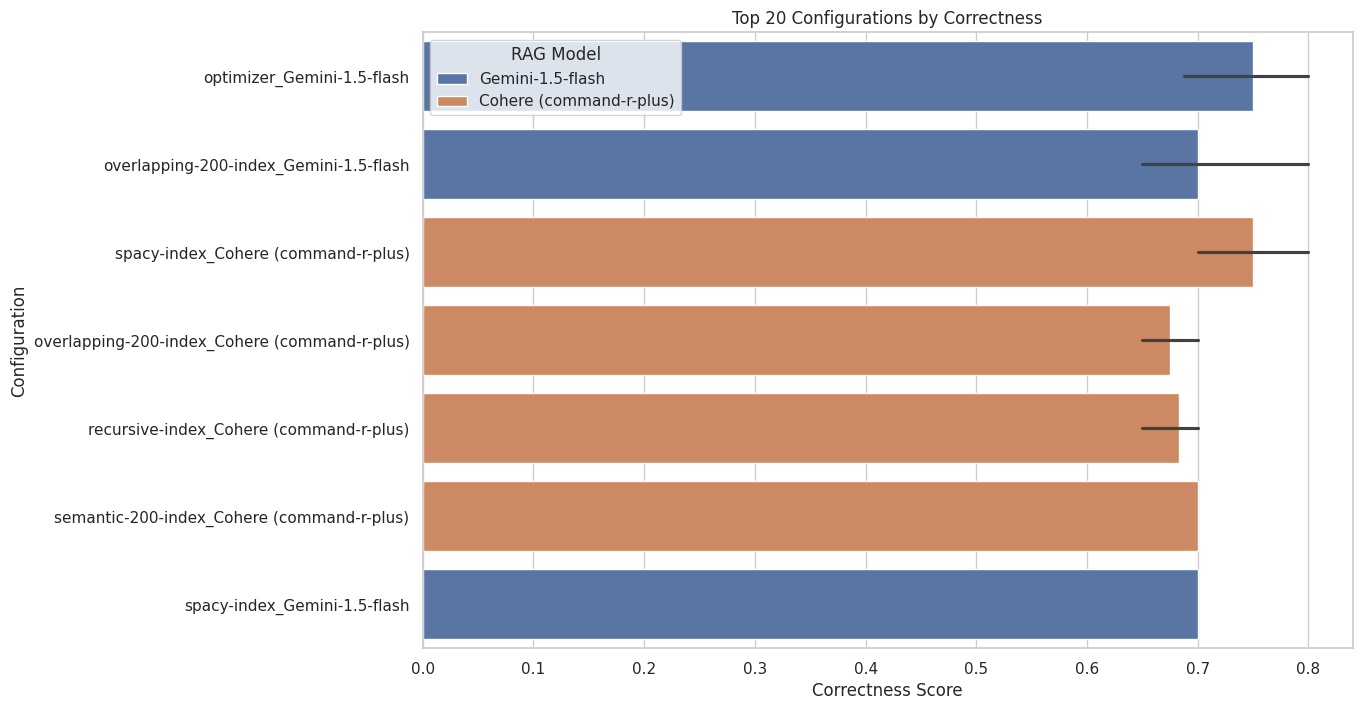

In [12]:

# 2. Top 20 Configurations by Correctness Score
plt.figure(figsize=(12, 8))
sns.barplot(x='correctness', y='config', hue='rag_model', data=top_20_by_correctness)
plt.title('Top 20 Configurations by Correctness')
plt.xlabel('Correctness Score')
plt.ylabel('Configuration')
plt.legend(title='RAG Model')
plt.show()


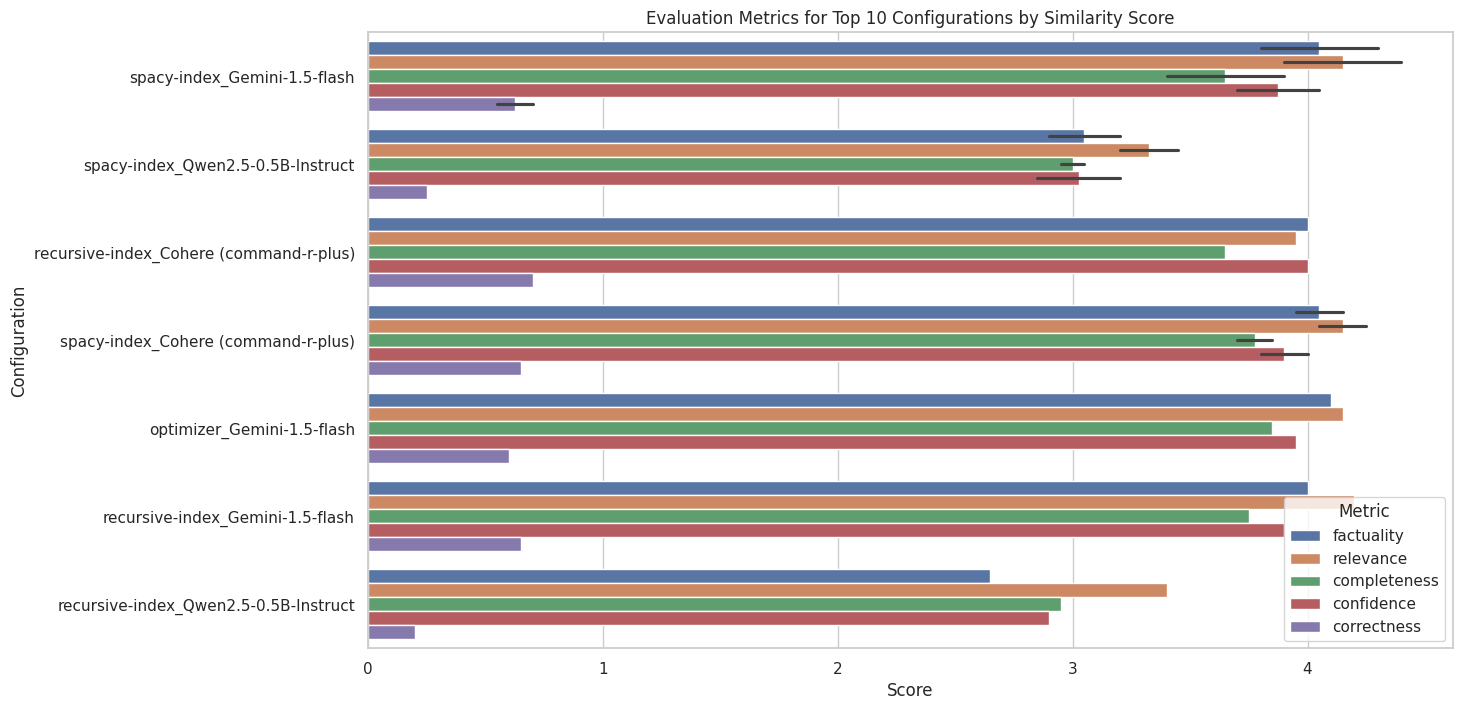

In [13]:
# 3. Evaluation Metrics by Configuration for Top 10 by Mean Similarity Score
top_10 = top_20_by_similarity.head(10)
eval_cols = ['factuality', 'relevance', 'completeness', 'confidence', 'correctness']
top_10_melted = top_10.melt(id_vars=['config', 'rag_model'], value_vars=eval_cols, var_name='Evaluation Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Score', y='config', hue='Evaluation Metric', data=top_10_melted, dodge=True)
plt.title('Evaluation Metrics for Top 10 Configurations by Similarity Score')
plt.xlabel('Score')
plt.ylabel('Configuration')
plt.legend(title='Metric')
plt.show()



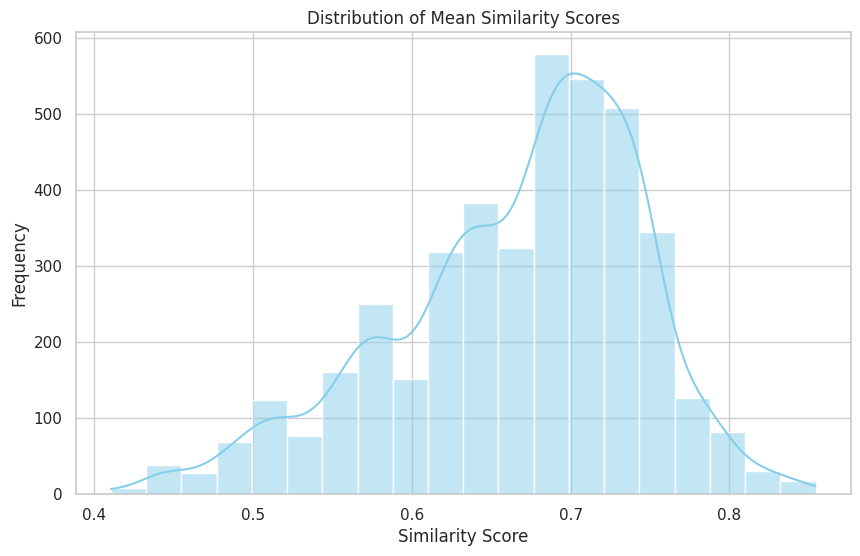

In [14]:
# 4. Mean Similarity Score Distribution Across Configurations
plt.figure(figsize=(10, 6))
sns.histplot(all_data['similarity_score'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of Mean Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()



<Figure size 1200x1000 with 0 Axes>

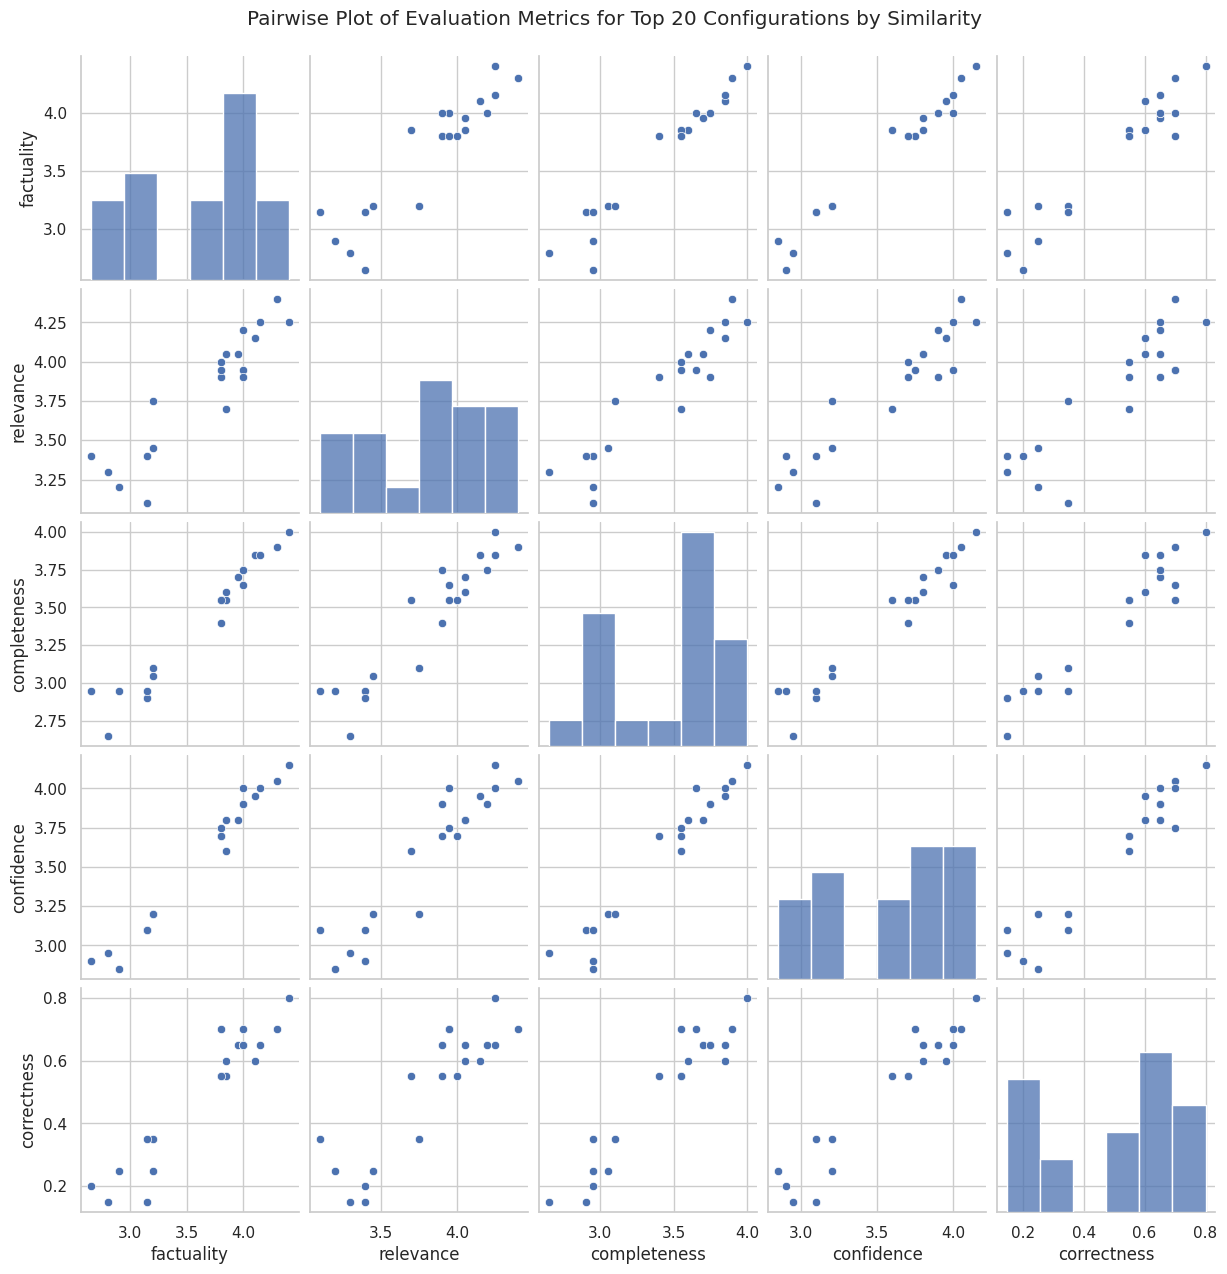

In [15]:
# 5. Pairwise Comparison of Evaluation Metrics (Top 20 Similarity Score Configurations)
plt.figure(figsize=(12, 10))
sns.pairplot(top_20_by_similarity[eval_cols])
plt.suptitle('Pairwise Plot of Evaluation Metrics for Top 20 Configurations by Similarity', y=1.02)
plt.show()



/tmp/ipykernel_3494/2873836694.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='optimizer', y='mean_similarity_score', data=agg_data, palette='Set2')


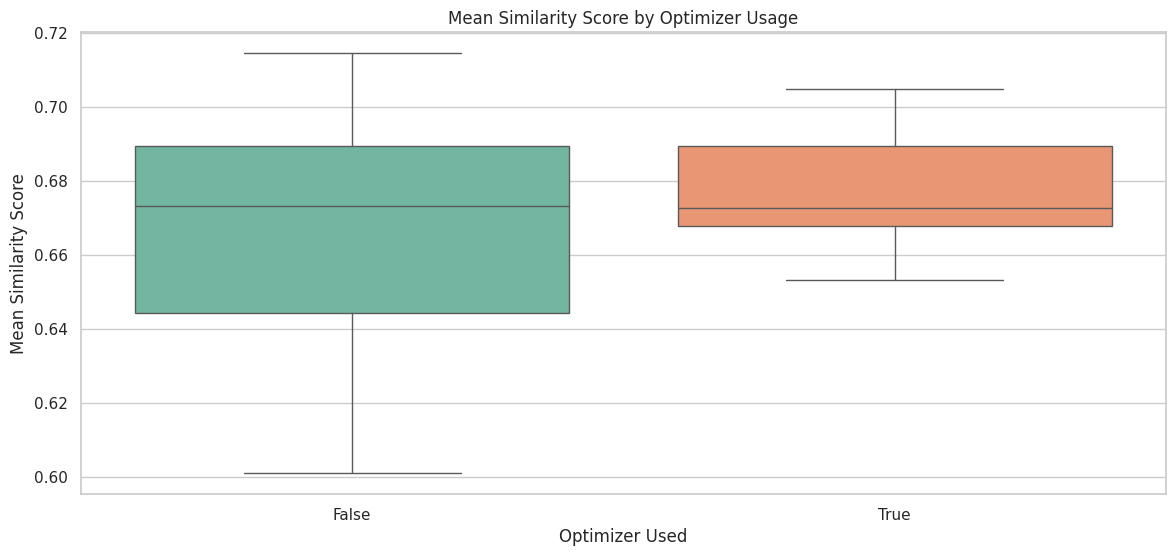

In [16]:
#6. Boxplot of Evaluation Metrics by Optimizer Use
plt.figure(figsize=(14, 6))
sns.boxplot(x='optimizer', y='mean_similarity_score', data=agg_data, palette='Set2')
plt.title('Mean Similarity Score by Optimizer Usage')
plt.xlabel('Optimizer Used')
plt.ylabel('Mean Similarity Score')
plt.show()



/tmp/ipykernel_3494/1489412918.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='additional_flags', y='relevance', data=agg_data, palette='muted')


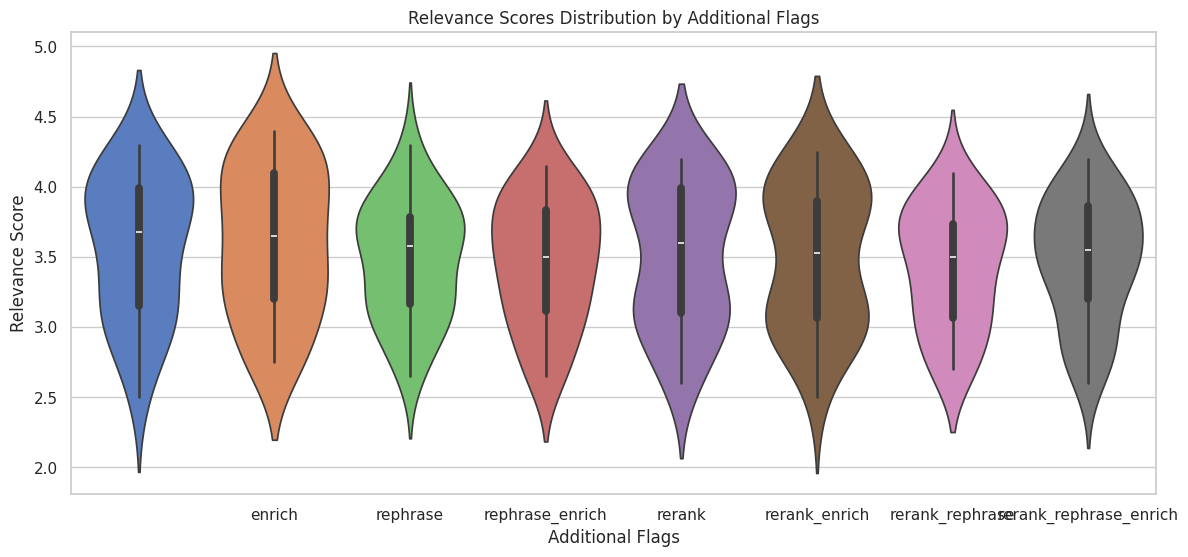

In [17]:
# 7. Violin Plot of Relevance Scores by Additional Flags
plt.figure(figsize=(14, 6))
sns.violinplot(x='additional_flags', y='relevance', data=agg_data, palette='muted')
plt.title('Relevance Scores Distribution by Additional Flags')
plt.xlabel('Additional Flags')
plt.ylabel('Relevance Score')
plt.show()

In [21]:
# best 20 overall score in box plots in RAG
# top 20 diff between mean accuracy with rag and direct
# best index from optimizer
# compare each from 'rerank','rephrase'.... to the option without it
# somehow similarity score

all_data['overall_score'] = (all_data['eval_factuality'] + all_data['eval_relevance'] + all_data['eval_completeness'] + all_data['eval_confidence']) / 4

In [ ]:
# aggerate over rag_model and additional_flags
rag_data = all_data[all_data['mode'] == 'RAG']

# Get the top 20 overall score in RAG
all_data[all_data['mode'] == 'RAG'].nlargest(20, 'overall_score')
